# Molecule unfolding: K-means clustering of experimental data

In this notebook we will describe the analysis procedure based on K-means clustering that can be used to follow different steps 
in the reaction of unfolding of protein molecules. 

This method can be also used to analyse data from other reactions involving polymer molecules. 

In [1]:
# Necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Load data into a dataframe
trace=pd.read_excel('trace.xlsx')

In [2]:
# Check the first few lows of the data
trace.head()

,time,length,force
0,32.2704,-2.57971,4.36977
1,32.2767,2.15869,4.36977
2,32.2829,-1.49097,4.36977
3,32.2892,0.81958,4.36977
4,32.2954,-2.87012,4.36977


A typical experimental data contains recordered data points stored in the following three columns:\
    
**time** is the number of seconds passed since the start of the recording\
    
**length** is the current length or extension of the molecule in nanometers\
    
**force** is the force in picoNewtons  with wchich the molecule is being pulled on. 


We can visualize how the length of the protein molecule changes with time during the course of the experiment
by plotting the length timeseries.

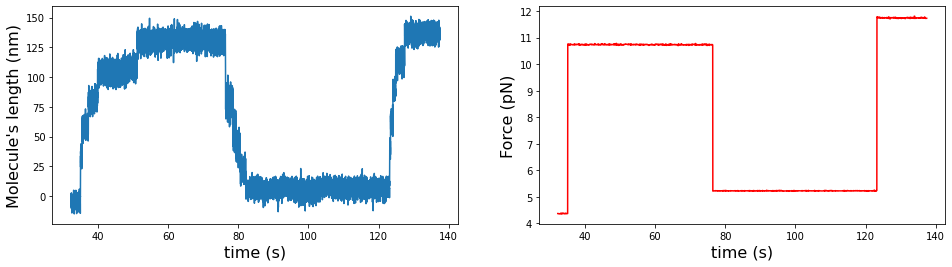

In [3]:
# Plot the protein length time series
f,ax=plt.subplots(1,2,figsize=(16,4))
ax[0].plot(trace['time'],trace['length'])
ax[0].set_ylabel("Molecule's length (nm)",fontsize=16)
ax[0].set_xlabel('time (s)',fontsize=16)
ax[1].plot(trace['time'],trace['force'],color='r')
ax[1].set_ylabel('Force (pN)',fontsize=16)
ax[1].set_xlabel('time (s)',fontsize=16)
plt.show()

In this experiment, we used a polyprotein molecule consisting of several identical domains joined in a chain.

When we pull on a protein molecule with a certain force, we can gradually unfold the polyprotein molecule domain by domain.

This is why we see different steps (or levels) of molecule's length - as we increase the force at wich we pull from 4.2 to 10.8
picoNewton (subplot on the right), the length of the molecule increases step by step till 140 nanometers (subplot on the left).
Every step here corresponds to an unfolding of one protein domain. 

When afterwards we decreased the force to low values (around time=75 seconds, subplot on the right), you can see the length 
steps again, but this time they are going down - the molecule length decreases. This step by step molecule length change 
corresponds to the gradual folding of the previously unfolded protein domains - each step corresponds to one domain.

Finally, when we increased the pulling force again at the time around 120 seconds (right subplot), you can see the
unfolding steps again (subplot on the left)

## Cluster molecule's length data and find domains centroids

Let's first take a closer look at the part of the data when we unfolded the molecule for the first time.

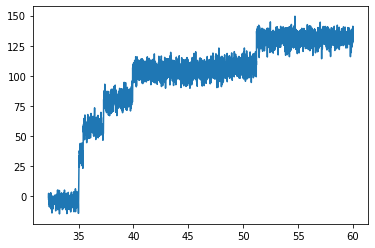

In [4]:
# Plot first unfolding cycle
unfold1=trace[(trace.time>30)&(trace.time<60)]
plt.plot(unfold1['time'],unfold1['length'])
plt.show()

You can notice that till the the second 35 the mollecule was completely folded - the length oscilated around 0 
nanometers.

Afterwards, there were 5 steps upstairs: one larger step from 0 to approximately 40 nm, followed by four more steps
of a similar size.

The first larger step here corresponds to the stretching of the molecule from a tangle to an extendeded form,and the four smaller step correspond to the unfolding of four identical protein domains joined into a chain.

We can see that, finally, when the fourd domains are unfold and the molecule is fully extended, its length reaches 
approximately 130 nm.

The goal of the analysis described in this notebook is to perform K-means clustering to identify the clusters in the molecule's
length data corresponding to different steps. As a results, we will be able to determine the length of each step, and thus,
we will gain the information about the size of the unfolding domains.



The K-means algorithm begins with a first group of randomly selected centroids, which are used as the starting points for every cluster, and then the algorithm performs iterative calculations to optimize the positions of the centroids.

Accordingly, we will divide the algorithm in steps:

**1.** Manual selection of the number of clusters, k, and random selection of k number of centroids for each cluster;\

**2.**  Assign all the points to the closest cluster centroid;

**3.** Recompute centroids of newly formed clusters;

**4.** Repeat steps **3** and **4** towards reducing the in-cluster sum of squares untill the difference between the previous and the current position of centroids is 0.


Now, we will define three functions to perform K-means clustering of our data. The function **random_centroid** will select k number of random centroids for each of k clusters, the function **centroids** will perform the steps **2**, **3** and **4** of 
the algorithm, and the function **plot_clusters** will plot the obtained clusters in our data together with the clusters' optimized centoids.


### Define functions necessary for clustering

In [5]:
# Function that accepts the number of clusters (k) and selects random centroid for each cluster
def random_centroid(K,df):
    
    """This function accepts the number of 
    clasters and the name of the dataframe with
    the protein the legth over time
    and selects random centroids for each cluster"""
    
    #K-number of clusters
    # Select random observation as centroids
    random_centroids = (df.sample(n=K))
    return random_centroids

In [6]:
# Function that assigns all the points to the closest cluster centroid and recomputes centroids of newly formed clusters
def centroids(K,df,centroids):
    
    """This function takes as an input the number of clusters,
    the name of the data frame and the random clasters defined previously 
    and recomputes centroids of newly formed clusters"""
    
    diff = 1
    j=0
    
   # We have initially defined the diff as 1 and inside the while loop, we are calculating this diff 
   # as the difference between the centroids in the previous iteration and the current iteration. 
    
    while(diff!=0):   # We are stopping the training when the centroids are not changing after two iterations.
        XD=df
        i=1
            
        for index1,row_c in centroids.iterrows():
            ED=[]
            for index2,row_d in XD.iterrows():
                d1=(row_c["time"]-row_d["time"])**2 #squared difference between x coordinate of random cluster and a current point
                d2=(row_c["length"]-row_d["length"])**2 # squared difference between y coordinate of random cluster and a current point
                d=np.sqrt(d1+d2) # square root error sum
                ED.append(d)
            df[i]=ED
            i=i+1
   
        # Create a list of cluster positions 
        Clust=[]
        for index,row in df.iterrows():
            min_dist=row[1]
            pos=1
            for i in range(K):
                 if row[i+1] < min_dist:
                        min_dist = row[i+1]
                        pos=i+1
            Clust.append(pos)
            
        #  Create a column with the clsuter number  
        df["Cluster"]=Clust
        centroids_new = df.groupby(["Cluster"]).mean()[["length","time"]]
        

        if j == 0:
            diff=1
            j=j+1
        else:
            # Calculate and print current difference
            diff = (centroids_new['length'] - centroids['length']).sum() + (centroids_new['time'] - centroids['time']).sum()
            print(diff.sum())
            
        # Final selected centroids 
        centroids = df.groupby(["Cluster"]).mean()[["length","time"]]
    return centroids

In [7]:
def plot_clusters(K,df, Centroids):
    color=['blue','green','cyan','black','orange','purple','grey']
    for k in range(K):
        data=df[df["Cluster"]==k+1]
        plt.scatter(data["time"],data["length"],c=color[k])
    plt.scatter(Centroids["time"],Centroids["length"],c='red')
    plt.xlabel('time (s)')
    plt.ylabel('length (nm)')
    plt.show()

### Find clusters for diffent molecule domains  and their centroids for unfolding

Let's now take a look at how the molecule's length changed when it was pulled on for the second time.

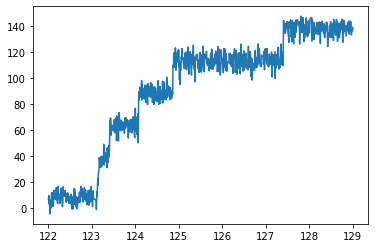

In [8]:
# Define and plot data for the second unfolding
unfold2=trace[(trace.time>122)&(trace.time<129)]
plt.plot(unfold2['time'],unfold2['length'])
plt.show()

We can observed that like in the first pulling, there were 5 steps upstairs: one larger step from 0 to approximately 40 nm, followed by four more steps of a similar size.

We will now use our K-means clustering algorithm to find the six following clusters corresponding to the different steps 
in the reaction: the first cluster will define the initial length of the molecule, the second cluster will correspond to the step of extending the molecule from a tangle, and the third, the fourth, the fifth and the sixth clusters will correspond to the unfolding of the first,the second, the third and the fourth protein domains correspondingly. 

In [9]:
# Select rendom cluster centroids for the second unfolding
random_centroids=random_centroid(6,unfold2)

In [10]:
# Recompute the centroids according to the k-meands algorithm
Centroids=centroids(6,unfold2,random_centroids)

0.39976995777650437
0.24797802813047554
0.1351011547298384
0.13738116372876163
0.2557577176287964
0.19117918317370197
0.09459128657744031
0.1639318769947522
0.14596324660506355
0.22009719005519912
0.15352736211804086
0.10203225779800107
0.10130460341997605
0.10011866017710247
0.048515998837700636
0.048458459943589105
0.0


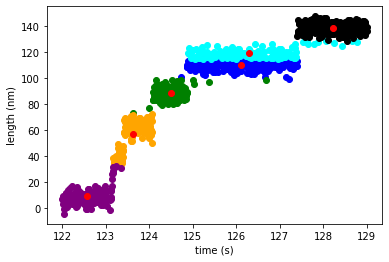

In [11]:
# Plot the obtained clusters together with the centroids
plot_clusters(6,unfold2,Centroids)

You can see that the algorithm with randomly preselected initial centroids could not correctly identify the clusters corresponding to the six steps of the reaction. 

The algorithm unified the steps corresponding to the unfolding of the first two protein domains (the yellow cluster contains the steps of the unfolding of two domains intead of just one), instead the
algorithm divided the second-last step into two clusters (the blue and the cyan clusters).

### Find clusters for diffent molecule domains  and their centroids for refolding

Let's now take a look at the refolding of the molecule.

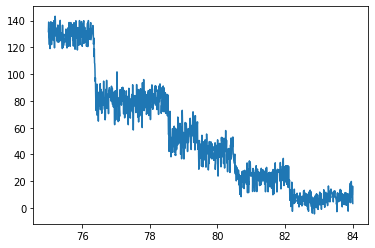

In [13]:
#Define and plot data for the refolding
refold1=trace[(trace.time>75)&(trace.time<84)]
plt.plot(refold1['time'],refold1['length'])
plt.show()

We can see that when we relaxed the pulling force the molecule gradually folded back to its initial state.

Let's now use the K-means clustering algorithm to identify different refolding reation steps.

In [14]:
# Select k random centroids 
random_centroids=random_centroid(6,refold1)

In [15]:
# Recompute the centroids according to the k-meands algorithm
Centroids=centroids(6,refold1,random_centroids)

9.449076124406533
11.62205597277848
19.57208536674951
21.86334935562901
5.930456716258697
3.2960509544663594
2.1544399153479574
2.230516259919119
1.861459359959416
2.020510793649259
1.8957412921237475
2.454606584533713
2.263537548053624
1.9402355179201614
1.885002997508142
1.7777857148860168
1.7940736110911448
1.9439996849660517
1.9784322732554536
1.4867984711474627
1.6596935020381887
1.6302982274057172
1.4532111837914066
1.384849756453285
1.3112432442945847
0.6289014905764034
0.8394533404836082
0.9047456732239638
0.6884741311422822
0.585311675985448
0.38523934834279316
0.3835069891951619
0.17610937331524212
0.16412787296155784
0.08745087828273768
0.0839135930406627
0.0


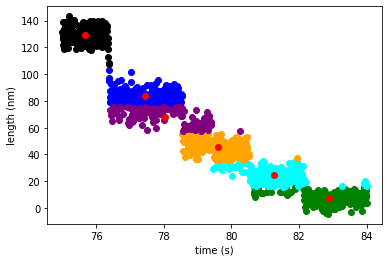

In [16]:
# Plot the obtained clusters together with their centorids
plot_clusters(6,refold1,Centroids)

We can see that the algorithm identified well the different steps in the refolding reaction too.


Finally, we will try to analyze the unfolding reaction occured when we pulled on the molecule the first time.

In [17]:
random_centroids=random_centroid(6,unfold1)

In [18]:
Centroids=centroids(6,unfold1,random_centroids)

-25.060321080656923
-13.865651790026366
-16.688116353320357
-20.659793820894976
-28.360150579767755
-11.725199982091883
-4.616206566997494
-2.4176216747225983
-1.8233900823920006
-1.745916677330317
-2.234184604020896
-2.5528021808145525
-3.471364853476608
-5.018774792085935
-4.982204256426925
-3.988704467152594
-3.2500737374882505
-2.427009101348766
-1.8526166476219563
-2.121781955909105
-1.779850008545913
-1.9427338025542085
-2.7672342038459914
-4.132084152320658
-5.455510608268238
-7.105244205580821
-8.886591212804714
-8.421592339036675
-3.9657404381290746
-1.1364786514413936
-0.4008839450893049
-0.21771484243316053
-0.1444462292633375
-0.124164718949622
0.0


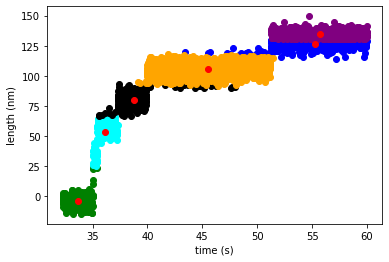

In [19]:
plot_clusters(6,unfold1,Centroids)

Oops... You can see that the K-means clustering with random selection of initial centroids was unable to identify
the small cluster corresponding to the initial extension of the molecule (from 0 to 35 nm), instead it divided the last step
into two clusters.

Let's try to improve the algorith by manually assigning the approximate coordinates of the initial cluster centroids!

### Improve the algorithm with an initial guess for centroids

In [20]:
#Assingn coordinates of initial centoids
time=[33,36,37,39,46,55]
length=[-4,26,56,80,105,130]
guess_centroids= pd.DataFrame(list(zip(time, length)),columns =['time', 'length'])
guess_centroids

,time,length
0,33,-4
1,36,26
2,37,56
3,39,80
4,46,105
5,55,130


Now, that we assigend the coordinates for the initial cluster centroids, let's perform the steps **2** - **4** of the algorithm.

In [21]:
Centroids=centroids(6,unfold1,guess_centroids)

2.064435672369364
0.23843202962048338
0.06802377513523084
0.0


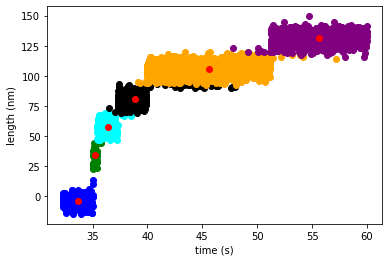

In [22]:
plot_clusters(6,unfold1,Centroids)

Wow, by assigning approximate initial coordinates of the centroids, the K-means algorithm was able to correctly define
the 6 clusters corresponding to different reaction steps.

Let's look at the obtained centroid coordinates and estimate the sizes of each reaction step.

In [23]:
Centroids

,length,time
Cluster,,
1,-4.489383,33.643408
2,33.733848,35.237083
3,57.509967,36.367127
4,80.613796,38.888454
5,105.703881,45.593464
6,131.032345,55.594710


Knowing the length coordinate of each cluster centroid we can estimate the size of ech step.

We can see that the length of the molecule due to the initial extension changed by around 37 nanometers (from the blue to
the green cluster). 

Then, the first domain unfolded, and the molecule's length changed from 33.7 nm to 57.5 nm (from the green cluster to 
the cyan cluster) so the size of the step was 23.5 nanometers. Afterwards, the second domain unfolded (change form the cyan to the black
cluster) with the step size of 80.6 - 57.5 = 23.1 nanometers (the same size as the previous step). Then, the third domain unfolded (change
from the black cluster to the orange one) changing the molecule's length by 105.7 - 80.6 = 25.1 nanometers. Finally, the fourth and the
last domain unfolded changing the molecule's length from 105.7 nm to around 131 nm (by 25.3 nanometers).

As you can see, with the K-means clustering algorithm with manually selected initial cluster centroids, we were able to precisely identify different unfolding reaction steps.



Just for fun, let's now perform the K-mean clustering using the scikit-learn library!

## K-Means Clustering with scikit-learn

Let's perform the K-means clustering of the refolding data.

In [24]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans

First, we need to bring all the variables to the same magnitude.

In [25]:
# standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
refold1=trace[(trace.time>75)&(trace.time<84)]
data_scaled = scaler.fit_transform(refold1)

# statistics of scaled data
pd.DataFrame(data_scaled).describe()

,0,1,2
count,1.373000e+03,1.373000e+03,1.373000e+03
mean,6.624142e-16,8.280178e-17,-5.796124e-16
std,1.000364e+00,1.000364e+00,1.000364e+00
min,-1.721885e+00,-1.443994e+00,-4.428009e-01
25%,-8.600403e-01,-8.515358e-01,-4.381299e-01
50%,1.883829e-04,-1.873029e-01,-4.362695e-01
75%,8.579926e-01,6.552682e-01,-4.334491e-01
max,1.739849e+00,2.123277e+00,2.295761e+00


A random initialization of the centroids can be problematic because we might get different clusters every time.

So, to solve this problem of random initialization, there is an algorithm called K-Means++ that can be used to choose the initial values, or the initial cluster centroids, for K-Means.

Let’s set the number of clusters as 6 and fit the model.

In [26]:
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=6, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans.fit(data_scaled)

KMeans(n_clusters=6)

We have fitted the model. Let’s now evaluate how well the obtained clusters are. 
To do that, we will calculate the inertia of the clusters: inertia estimates how far the points within a cluster are.
So, inertia actually calculates the sum of distances of all the points within a cluster from the centroid of that cluster.

In [27]:
# inertia on the fitted data
kmeans.inertia_

86.73172482770934

We can plot the values of Intertia we will obtain with the model for different number of clusters.
The optimal value of Inertia is the value corresponding to the 'elbow' of the graph

Text(0, 0.5, 'Inertia')

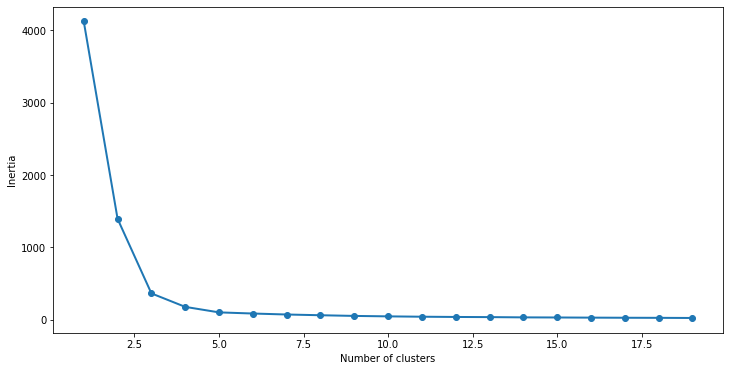

In [28]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o',lw=2)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

We can see that the optimal number of clusters (the elbow point) would be 4 or 5. However, based on our knowledge of the
reaction process, we know that there should be six clusters in our data.

Let's fit the model again and check out the resulting clusters.

In [29]:
# k means using 5 clusters and k-means++ initialization
kmeans = KMeans(n_clusters = 6, init='k-means++')
kmeans.fit(data_scaled)
pred = kmeans.predict(data_scaled)

We store the predicted clusters in the variablle pred and we add the predictions in the column 'cluster' to thec data frame
with the refolding cluster.

In [30]:
refold1['cluster'] = pred
refold1['cluster'].value_counts()

1    321
0    279
4    250
2    220
3    166
5    137
Name: cluster, dtype: int64

Let's now visualize the obtained clusters.

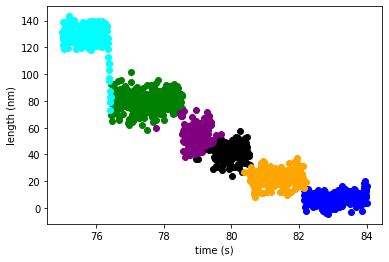

In [31]:
# plot clusters
color=['blue','green','cyan','black','orange','purple']
K=6
for k in range(K):
    data=refold1[refold1["cluster"]==k]
    plt.scatter(data["time"],data["length"],c=color[k])   
plt.xlabel('time (s)')
plt.ylabel('length (nm)')
plt.show()

As we can see that the clusters have different amounts of points, from 137 for the cluster 4 (the purple) to
321 points in the cluster 2 (the cyan cluster)

In conclusion, we used K-means clustering to identify different steps in the molecule unfolding and refolding reactions.
This approach can be used to analyze the data from other different reactions in which the length of the molecule changes in time,
e.g., DNA polymerization reaction.